In [2]:
# We need to install this library to get our satellite data easily
!pip install tensorflow_datasets

# Now we import our "toolkits"
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Set our standards
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define a function to resize and normalize images
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Scale pixel values to 0-1
    return image, label

# Load the dataset using efficient splits
# This tells tfds to only load the slices we need, one by one.
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'eurosat/rgb',
    # This is the magic part: it streams the splits directly.
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True, # Returns (image, label) pairs
    with_info=True
)

# Get the human-readable names for the categories (like 'Forest')
CLASS_NAMES = ds_info.features['label'].names
print("Categories:", CLASS_NAMES)

# Create the final data pipelines
# We apply the preprocessing, batching, and prefetching
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Data pipelines created successfully.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.X81DP9_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Categories: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Data pipelines created successfully.


In [4]:
# 1. Get the pre-trained "engine" (MobileNetV2)
# We don't include its original 'top' layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,), # (224, 224, 3-color-channels)
    include_top=False,
    weights='imagenet' # Load weights pre-trained on 1.4 million images
)

# 2. Freeze the "engine"
# We don't want to change the parts that are already expert at seeing
base_model.trainable = False

# 3. Build our new model by stacking our new parts on top
model = tf.keras.Sequential([
    base_model,  # The frozen expert engine
    tf.keras.layers.GlobalAveragePooling2D(), # A layer to simplify the output
    tf.keras.layers.Dropout(0.2), # Helps prevent the model from 'cheating'
    tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax') # The final decision layer
                                                                # 'softmax' makes it pick one category
])

# 4. "Compile" the model (put all the pieces together)
model.compile(
    optimizer='adam', # The 'adam' optimizer is a good, fast default
    loss='sparse_categorical_crossentropy', # This measures how 'wrong' the model is
    metrics=['accuracy'] # We want to track its accuracy
)

# Print a summary of our model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# This step will take 5-10 minutes. Watch the 'val_accuracy' go up!
print("Starting training...")
history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val
)
print("Training finished!")

Starting training...
Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.7536 - loss: 0.7319 - val_accuracy: 0.9052 - val_loss: 0.2816
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.8975 - loss: 0.2934 - val_accuracy: 0.9144 - val_loss: 0.2452
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9101 - loss: 0.2621 - val_accuracy: 0.9174 - val_loss: 0.2406
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9143 - loss: 0.2405 - val_accuracy: 0.9196 - val_loss: 0.2295
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.9221 - loss: 0.2211 - val_accuracy: 0.9200 - val_loss: 0.2308
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9221 - loss: 0.2212 - val_accuracy: 0.9244 - val_loss: 0.2269
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9275 - loss: 0.2044 - val_accuracy: 0.9259 - val_loss: 0.2168
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9

In [6]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(ds_test)

print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9170 - loss: 0.2150
Final Test Accuracy: 91.63%


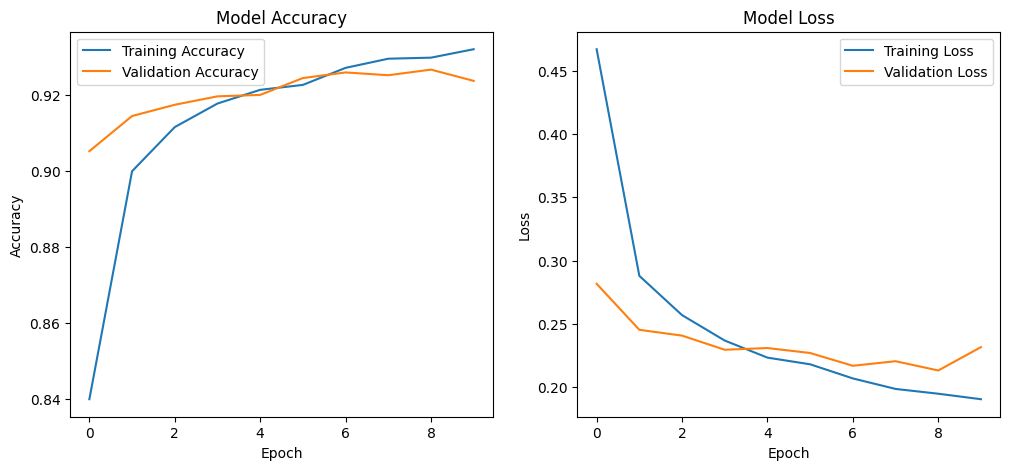

In [7]:
# Create a figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot Accuracy ---
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# --- Plot Loss ---
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.show()

In [8]:
# Save the entire model to a single file.
# The .keras format is the new standard and saves everything.
model.save('my_land_use_model.keras')

print("Model saved to my_land_use_model.keras")

Model saved to my_land_use_model.keras
